# Uninteracting H


In [35]:
using LinearAlgebra
#using PlotlyJS
using Plots
using HDF5
using Einsum
using ProgressMeter
using Statistics
using DelaunayTriangulation
using Base.Threads
using Colors
using Distributed

In [36]:
Gs = zeros(6, 2)
Gs[1, :] .= [0, 1] .* (2 * π)
Gs[2, :] .= [-cos(π / 6), sin(π / 6)] .* (2 * π)
Gs[3, :] .= [-cos(π / 6), -sin(π / 6)] .* (2 * π)
Gs[4, :] .= [0, -1] .* (2 * π)
Gs[5, :] .= [cos(π / 6), -sin(π / 6)] .* (2 * π)
Gs[6, :] .= [cos(π / 6), sin(π / 6)] .* (2 * π)

2-element view(::Matrix{Float64}, 6, :) with eltype Float64:
 5.441398092702654
 3.1415926535897927

In [ ]:
l = 10
filename="data10valenceud8nu1ang01588eps8bands4val.h5"
nflav = 8
cutoff = 3
nbandkeep = 4
epsilond=8
a_G = 0.246
a_hBN = 0.25025
theta = 0.1588 * π / 180
epsilon = 1 - (a_G / a_hBN)
ratio = 1 / sqrt(epsilon^2 + theta^2)
angle = atan(theta / epsilon)
am=a_G*ratio

# Additional parameters
ud = 8
delt = 12.2
ua = -16.4
t0 = 2600
t1 = 356.1
t2 = -15
t3 = -293
t4 = -144

# Coefficients
CAA = -14.88
CBB = 12.09
CAB = 11.34
phiaa = 50.19 * π / 180
phibb = -46.64 * π / 180
phiab = 19.60 * π / 180

0.3420845333908886

In [38]:
ks = zeros(Float64, l * l, 2)
for i in 1:(l * l)
    xi = (i - 1) % l  # Adjust for 1-based indexing
    yi = div(i - 1, l)  # Integer division
    xcoord = yi * 2 * π * cos(π / 6) / (l)
    ycoord = 2 * yi * π / (l) * sin(π / 6) + xi * 2 * π / (l) 
    ks[i, :] .= [xcoord, ycoord]
end

In [39]:
function makeH0(q, g = [0.0, 0.0])
    kx = (q[1] + g[1]) / ratio
    ky = (q[2] + g[2]) / ratio
    z = (kx + im * ky) * exp(-im * angle)
    ht = zeros(Complex{Float64}, nflav, nflav)

    ht[1, 2] = t0 * conj(z)
    ht[1, 3] = t4 * conj(z)
    ht[1, 4] = t3 * z
    ht[1, 6] = t2 / 2
    ht[2, 3] = t1
    ht[2, 4] = t4 * conj(z)
    ht[3, 4] = t0 * conj(z)
    ht[3, 5] = t4 * conj(z)
    ht[3, 6] = t3 * z
    ht[3, 8] = t2 / 2
    ht[4, 5] = t1
    ht[4, 6] = t4 * conj(z)
    ht[5, 6] = t0 * conj(z)
    ht[5, 7] = t4 * conj(z)
    ht[5, 8] = t3 * z
    ht[6, 7] = t1
    ht[6, 8] = t4 * conj(z)
    ht[7, 8] = t0 * conj(z)

    Hzer = ht + conj(transpose(ht))
    Hzer[1, 1] = ud * 3/2
    Hzer[2, 2] = 3/2 * ud + delt
    Hzer[3, 3] = ud/2 + ua
    Hzer[4, 4] = ud/2 + ua
    Hzer[5, 5] = ua-ud/2
    Hzer[6, 6] = ua-ud/2
    Hzer[7, 7] = delt - ud*3/2
    Hzer[8, 8] = - ud*3/2

    return Hzer
end

makeH0 (generic function with 2 methods)

In [40]:
glist = []
for ip in 1:20
    for jp in 1:20
        it = ip - 11  # Adjust for 1-based indexing
        jt = jp - 11

        gc = [0, 2 * π] * it + [cos(π / 6), sin(π / 6)] * jt * 2 * π

        if norm(gc) <= 2 * π * cutoff + 0.01
            push!(glist, gc)
        end
    end
end
#glist = hcat(glist...)  # Transpose the list of vectors into a matrix
glist = vcat(glist...)  # Vertically concatenate all arrays in glist
glist = reshape(glist, 2, :)'  # Reshape into a matrix with 2 columns
nband = size(glist, 1) * nflav  # Number of bands

488

In [41]:
function whichGj(a, b)
  for i in 1:6  # Adjust for 1-based indexing
      if norm(glist[b,:] - glist[a,:] - Gs[i, :]) < 0.001
          return i
      end
  end
  return -1
end

whichGj (generic function with 1 method)

In [42]:
function makeV(l)
  V = zeros(Complex{Float64}, nflav, nflav)  # Initialize a complex matrix

  if l == 1
      V[1, 1] = CAA * exp(-im * phiaa)
      V[2, 2] = CBB * exp(-im * phibb)
      V[1, 2] = CAB * exp(2im * π / 3) * exp(-im * phiab)
      V[2, 1] = CAB * exp(2im * π / 3) * exp(-im * phiab)
  elseif l == 2
      V[1, 1] = CAA * exp(im * phiaa)
      V[2, 2] = CBB * exp(im * phibb)
      V[1, 2] = CAB * exp(im * phiab)
      V[2, 1] = CAB * exp(2im * π / 3) * exp(im * phiab) 
  elseif l == 3
      V[1, 1] = CAA * exp(-im * phiaa)
      V[2, 2] = CBB * exp(-im * phibb)
      V[1, 2] = CAB * exp(-im * phiab)
      V[2, 1] = CAB * exp(-2im * π / 3) * exp(-im * phiab)
  elseif l == 4
      V[1, 1] = CAA * exp(im * phiaa)
      V[2, 2] = CBB * exp(im * phibb)
      V[1, 2] = CAB * exp(-2im * π / 3) * exp(im * phiab)
      V[2, 1] = CAB * exp(-2im * π / 3) * exp(im * phiab)
  elseif l == 5
      V[1, 1] = CAA * exp(-im * phiaa)
      V[2, 2] = CBB * exp(-im * phibb)
      V[1, 2] = CAB * exp(-2im * π / 3) * exp(-im * phiab)
      V[2, 1] = CAB * exp(-im * phiab)
  elseif l == 6
      V[1, 1] = CAA * exp(im * phiaa)
      V[2, 2] = CBB * exp(im * phibb)
      V[1, 2] = CAB * exp(2im * π / 3) * exp(im * phiab)
      V[2, 1] = CAB * exp(im * phiab)
  end

  return V
end


makeV (generic function with 1 method)

In [43]:
function makeHM()
  HM = zeros(Complex{Float64}, nband, nband)  # Initialize a complex matrix

  for (igg, g1) in enumerate(eachrow(glist))
      for (jgg, g2) in enumerate(eachrow(glist))
          ig=igg-1
          jg=jgg-1
          HM[nflav*ig + 1:nflav*(ig + 1), nflav*jg + 1:nflav*(jg + 1)] += makeV(whichGj(igg, jgg))
      end
  end

  return HM
end

makeHM (generic function with 1 method)

In [44]:
function makeH(q)
  H0 = zeros(Complex{Float64}, nband, nband)  # Initialize a complex matrix

  for (igg, g) in enumerate(eachrow(glist))
    ig=igg-1
    # print(q)
    # print(g)
    H0[nflav*ig + 1:nflav*(ig + 1), nflav*ig + 1:nflav*(ig + 1)] += makeH0(q, g)
  end

  return H0 - makeHM()
end

makeH (generic function with 1 method)

In [45]:
function band(q, n)
  eigenvals, _ = eigen(makeH(q))  # Compute eigenvalues and eigenvectors
  return eigenvals[n + 1]  # Adjust for 1-based indexing
end


band (generic function with 1 method)

#  Tests

In [46]:
function high_symm_line()
  delta_k = [0.0, 0.0]
  ndiv = 20
  nbandplot = 8
  Gamma = Gs[1, :] * 0
  K = Gs[1, :] * (1 / 3) + Gs[6, :] * (1 / 3)
  Kp = Gs[1, :] * (-1 / 3) + Gs[6, :] * (2 / 3)
  Mpp = Gs[6, :] * (1 / 2)
  Mp = -Gs[1, :] * (1 / 2)
  M = Gs[1, :] * (-1 / 2) + Gs[6, :] * (1 / 2)

  ksline = [zeros(2)]
  kabs = [0.0]


  for i in 1:ndiv
      push!(ksline, (K - Gamma) / ndiv * i)
      push!(kabs, norm((K - Gamma) / ndiv) + kabs[end])
  end
  lab1 = kabs[end]

  for i in 0:ndiv
      push!(ksline, K + (Kp - K) / ndiv * (i + 1))
      push!(kabs, norm((Kp - K) / ndiv) + kabs[end])
  end
  lab2 = kabs[end]

  for i in 0:ndiv
      push!(ksline, Kp + (Gamma - Kp) / ndiv * (i + 1))
      push!(kabs, norm((Gamma - Kp) / ndiv) + kabs[end])
  end
  lab3 = kabs[end]

  for i in 1:ndiv
      push!(ksline, (M - Gamma) / ndiv * i)
      push!(kabs, norm((M - Gamma) / ndiv) + kabs[end])
  end
  lab4 = kabs[end]

  for i in 1:ndiv
      push!(ksline, M + (Mp - M) / ndiv * i)
      push!(kabs, norm((Mp - M) / ndiv) + kabs[end])
  end
  lab5 = kabs[end]

  for i in 1:ndiv
      push!(ksline, Mp + (Gamma - Mp) / ndiv * i)
      push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
  end
  lab6 = kabs[end]

  for i in 1:ndiv
      push!(ksline, (Mpp - Gamma) / ndiv * i)
      push!(kabs, norm((Mpp - Gamma) / ndiv) + kabs[end])
  end
  lab7 = kabs[end]

  for i in 1:ndiv
      push!(ksline, Mpp + (M - Mpp) / ndiv * i)
      push!(kabs, norm((M - Mpp) / ndiv) + kabs[end])
  end
  lab8 = kabs[end]

  for i in 1:ndiv
      push!(ksline, M + (Gamma - M) / ndiv * i)
      push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
  end
  lab9 = kabs[end]


    

  ksline = hcat(ksline...)
  ksline1=reshape(ksline, 2, :)'
  kabs = collect(kabs)

  band = zeros(Complex{Float64}, nbandplot, length(kabs))
  
  for (ind, q) in enumerate(eachrow(ksline1))
    #println(ind)
    eigenvals, _ = eigen(makeH(q))
    for i in 1:nbandplot
        band[i, ind] = eigenvals[div(nband, 2) - div(nbandplot, 2) + i]
    end
  end

  

    plot_size = (1000, 600)
    p = plot(size=plot_size)
    for i in 1:size(band, 1)
        plot!(kabs, real(band[i, :]),legend=false)
    end
    special_points = [0, lab1, lab2, lab3, lab4, lab5, lab6, lab7, lab8, lab9]
    special_labels = ["G", "K", "Kp", "G", "M", "Mp", "G", "Mpp", "M", "G"]
    xticks!(special_points, special_labels)
    ylabel!("E (meV)")
    display(p)

end

high_symm_line (generic function with 1 method)

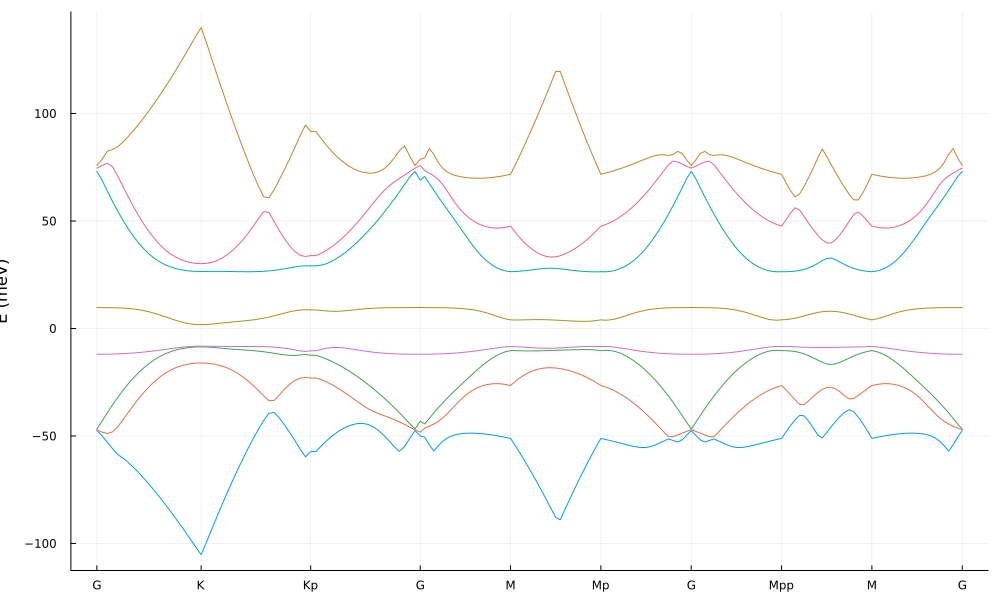

In [47]:
high_symm_line()

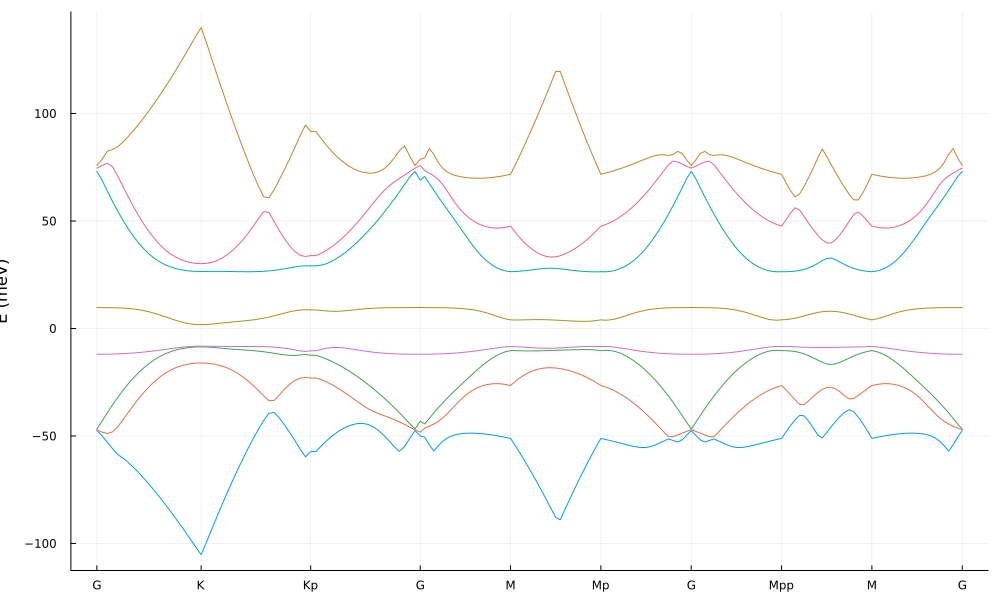

In [48]:
high_symm_line()

# Mean field


In [49]:
uinit = zeros(Complex{Float64}, l * l, nbandkeep, size(glist, 1), nflav)  # Complex array
eps0init = zeros(Complex{Float64}, l * l, nbandkeep)  # Complex array

@everywhere function compute_eigenvalues(ik, ks, nbandkeep, nflav, glist)
    engs, us = eigen(makeH(ks[ik, :]))  # `eigen` returns eigenvalues and eigenvectors
    eps0_local = zeros(Complex{Float64}, nbandkeep)
    u_local = zeros(Complex{Float64}, nbandkeep, size(glist, 1), nflav)

    for j in 1:nbandkeep
        eps0_local[j] = -engs[(nband ÷ 2) + 1-j]  # Adjust indexing for 1-based indexing in Julia
        for uind in 1:(nflav * size(glist, 1))
            u_local[j, div(uind - 1, nflav) + 1, rem(uind - 1, nflav) + 1] = us[uind, (nband ÷ 2) +1- j]
        end
    end

    return (eps0_local, u_local)  # Return local results as a tuple
end

# Initialize arrays to store results
uinit = zeros(Complex{Float64}, l * l, nbandkeep, size(glist, 1), nflav)
eps0init = zeros(Complex{Float64}, l * l, nbandkeep)

# Create a list of tasks for each ik
tasks = 1:(l * l)

# Use pmap to parallelize the computation
results = pmap(ik -> compute_eigenvalues(ik, ks, nbandkeep, nflav, glist), tasks)

# Collect results into the global arrays
for (ik, (eps0_local, u_local)) in enumerate(results)
    eps0init[ik, :] .= eps0_local  # Store the local eps0 results
    for j in 1:nbandkeep
        for uind in 1:(nflav * size(glist, 1))
            uinit[ik, j, div(uind - 1, nflav) + 1, rem(uind - 1, nflav) + 1] = u_local[j, div(uind - 1, nflav) + 1, rem(uind - 1, nflav) + 1]
        end
    end
end
h5write(filename, "u", uinit)
h5write(filename, "eps0", eps0init)
# Now uinit and eps0init are populated with parallel computation results


In [50]:
u = h5read(filename, "u");
eps0=real(h5read(filename, "eps0"));

In [51]:
eps0[1,:]

4-element Vector{Float64}:
 11.984945490102064
 46.74261279720848
 47.08138612088095
 47.46748361841639

In [52]:
laminit=zeros(Complex{Float64}, l * l,l*l,size(glist, 1), nbandkeep, nbandkeep);

In [53]:
sumG=zeros(Int64, size(glist, 1),size(glist, 1));

for ig in 1:size(glist, 1)
    for iG in 1:size(glist, 1)
        gind=-1
        for i in 1:size(glist,1)
            if (norm(glist[ig,:]+glist[iG,:]-glist[i,:])<0.001)
                gind=i
            end
        end
        sumG[ig,iG]=gind
    end
end    

In [54]:
@everywhere function compute_laminit(ik, ikp, iG, u, sumG, nbandkeep, nflav)
    ans_matrix = zeros(ComplexF64, nbandkeep, nbandkeep)
    
    for al in 1:nbandkeep
        for alp in 1:nbandkeep
            ans = 0.0 + 0.0im  # Initialize ans to complex zero
            for (g, gG) in enumerate(sumG[:, iG])
                if (gG != -1)
                    ans += sum(conj(u[ik, al, g, li]) .* u[ikp, alp, gG, li] for li in 1:nflav)
                end
            end
            ans_matrix[al, alp] = ans
        end
    end
    return (ik, ikp, iG, ans_matrix)  # Return the results as a tuple
end

# Define the size of laminit
laminit = zeros(ComplexF64, l * l, l * l, size(glist, 1), nbandkeep, nbandkeep)

# Define a list of tasks to be parallelized
tasks = [(ik, ikp, iG) for ik in 1:l*l, ikp in 1:l*l, iG in 1:size(glist, 1)]

# Progress meter to track progress
@showprogress "Computing laminit in parallel..." pmap(task -> begin
    (ik, ikp, iG) = task
    compute_laminit(ik, ikp, iG, u, sumG, nbandkeep, nflav)
end, tasks)

# Gather the results and populate laminit
for (ik, ikp, iG, ans_matrix) in pmap(task -> compute_laminit(task[1], task[2], task[3], u, sumG, nbandkeep, nflav), tasks)
    laminit[ik, ikp, iG, :, :] = ans_matrix
end

Computing laminit in parallel... 100%|███████████████████| Time: 0:00:30


In [55]:
h5write(filename, "lam", laminit)

In [56]:
lam=h5read(filename, "lam");

In [57]:
lam[1,1,1,1,1]

-4.752007984618584e-10 - 1.684566898929042e-10im

In [58]:
utensinit=zeros(Complex{Float64}, l * l,l*l,size(glist,1));

In [59]:
function v(ik, ikp, ig, li=0, lp=0)
    mom = norm(ks[ikp,:] + glist[ig,:] - ks[ik,:])
    formfactor = 1.0
    if mom < 1e-4
        return formfactor * 1306 * 30/am/am /(l*l)*8/(epsilond)
    end
    return formfactor * 1306/am / mom * tanh(mom * 30/am) /(l*l)*8/(epsilond)
  end;

In [60]:
v(1,1,19)

0.04032543458885876

In [61]:
@showprogress for ik in 1:l*l 
    for ikp in 1:l*l 
       for iG in 1:size(glist, 1)
           utensinit[ik,ikp,iG]=v(ik,ikp,iG)
       end
   end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [62]:
h5write(filename, "utens", utensinit)

In [63]:
utens=h5read(filename, "utens");

In [64]:
println(norm(utens))
println(norm(lam))

80.21222094469107
232.4164397206034


In [65]:
@einsum monsh[ik, ikp,al,alp,bet,betp] := utens[ik, ik,ig] * lam[ik, ik,ig,al,alp]*conj(lam[ikp,ikp,ig,betp,bet]);
@einsum monsf[ik, ikp,al,alp,bet,betp] := utens[ik, ikp,ig] * lam[ik, ikp,ig,al,betp]*conj(lam[ik,ikp,ig,alp,bet]);

In [66]:
monsh=monsh;
monsf=monsf*(-1);

In [67]:
h5write(filename, "monsh", monsh)
h5write(filename, "monsf", monsf)

In [68]:
monsh=h5read(filename, "monsh");
monsf=h5read(filename, "monsf");

# Iterations


In [69]:
monsh=h5read(filename, "monsh");
monsf=h5read(filename, "monsf");
u = h5read(filename, "u");
eps0=real(h5read(filename, "eps0"));

In [70]:
# bn=0.01
# monsh=monsh/bn;
# monsf=monsf*(-1)/bn;

In [71]:

hdiag=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
for i in 1:l*l 
    for j in 1:nbandkeep
        hdiag[i,j,j]=eps0[i,j]
    end
end

In [72]:
eng=zeros(Float64, l * l,nbandkeep);
filling=1.0
mu = quantile(collect(Iterators.flatten(eps0)), 1/size(eng,2)*filling);
rho=rand(Complex{Float64}, l * l,nbandkeep,nbandkeep)*0.1;

In [73]:
rhotest=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
for i in 1:l*l 
    rhotest[i,1,1]=1
end 
@einsum Hcurhtest[ik,al,alp] := monsh[ik,ikp,al,alp,bet,betp] * rhotest[ikp,bet,betp] 
@einsum Hcurftest[ik,al,alp] := monsf[ik,ikp,al,alp,bet,betp] * rhotest[ikp,bet,betp];


In [74]:
Hcurhtest[1,1,1]

191.70524415032696 - 3.077961205090411e-20im

In [75]:
ans=0
for i in 1:l*l 
    ans+=Hcurhtest[i,1,1]
end
ans=ans/l/l

191.71509441749683 - 3.9017855514674845e-20im

In [76]:
ans1=0
for i in 1:l*l 
    ans1+=Hcurftest[i,1,1]
end
ans1=ans1/l/l

-35.73482218643877 + 8.211571143144938e-19im

In [77]:
ans2=0
for i in 1:l*l 
    ans2+=hdiag[i,1,1]
end
ans2=ans2/l/l

9.840176850520248 + 0.0im

In [78]:
println(norm(monsh))
print(norm(monsf))

767.1878748847637
180.6433417634175

In [ ]:
nit=9000
engprev=0
urho=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
for ni in 1: nit
    ucur=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
    @einsum Hcurh[ik,al,alp] := monsh[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
    @einsum Hcurf[ik,al,alp] := monsf[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
    Hc=hdiag+Hcurh+Hcurf
    for ik2 in 1:l*l 
        engs, us = eigen(Hc[ik2,:,:])
        #println(norm(Hc[ik2,:,:]-conj(transpose(Hc[ik2,:,:]))))
        eng[ik2,:]=real(engs)
        ucur[ik2,:,:]=us
    end
    mu = quantile(real(collect(Iterators.flatten(eng))), 1/size(eng,2)*filling)
    rho=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
    for jk in 1:l*l 
        for bet in 1:nbandkeep
            for betp in 1:nbandkeep
                for n in 1:nbandkeep
                    rho[jk,bet,betp]+=conj(ucur[jk,bet,n])*ucur[jk,betp,n]/(1+exp((eng[jk,n]-mu)/0.01))
                end  
            end
        end
    end    
    println(eng[1,1])
    if (abs(engprev-eng[1,1])<1e-4)
        break
    end
    engprev=eng[1,1]
    urho=ucur
end

46.51646266171708
173.39601759281243
158.52322683224557
158.23571068732164
158.2248601757729
158.2535712641664
158.28339897364359
158.3136032793005
158.3434887474208
158.37207667763576

In [429]:
mu

178.93022706489472

In [430]:
eng[1,:]

4-element Vector{Float64}:
 158.88541741604524
 233.77990223336258
 234.47831612136738
 234.59357025225407

In [431]:
eps0[1,:]

4-element Vector{Float64}:
 11.984945490097516
 46.74261294701627
 47.081386356739124
 47.46748407020086

In [432]:
maximum(eng[:,1])

174.85365633445122

In [433]:
minimum(eng[:,2])

180.28908397504256

In [434]:
size(collect(Iterators.flatten(eng)))

(400,)

In [455]:
ind5=0
for i in 1:400
    if (collect(Iterators.flatten(eng))[i]<quantile(real(collect(Iterators.flatten(eng))), 1/size(eng,2)*1))
        ind5+=1
    end
end

In [456]:
ind5

100

In [437]:
h5write(filename, "urho", urho)
h5write(filename, "rho", rho)
h5write(filename, "mu", mu)

# Highsymmetry HF


In [438]:
u = h5read(filename, "u");
eps0=real(h5read(filename, "eps0"));
lam=h5read(filename, "lam");
rho=h5read(filename, "rho");
uhf=h5read(filename, "urho");
mu=h5read(filename, "mu");

In [439]:
function vhf(q, ikp, ig, li=0, lp=0)
    mom = norm(ks[ikp,:] + glist[ig,:] - q)
    formfactor = 1.0
    if mom < 1e-4
        return formfactor * 1306 * 30/am/am /(l*l)*8/(epsilond)
    end
    return formfactor * 1306/am / mom * tanh(mom * 30/am) /(l*l)*8/(epsilond)
  end;

In [440]:
function makeH_HF(q)
    engs, us = eigen(makeH(q))
    uinit = zeros(Complex{Float64}, nbandkeep, size(glist, 1), nflav)  # Complex array
    eps0init = zeros(Float64, nbandkeep)  # Complex array
    for j in 1:nbandkeep
        eps0init[j] = -engs[(nband ÷ 2) + 1 - j]  # Adjust indexing for 1-based indexing in Julia
        for uind in 1:(nflav * size(glist, 1))
            uinit[j, div(uind - 1, nflav) + 1, rem(uind - 1, nflav) + 1] = us[uind,(nband ÷ 2) + 1 - j]
        end
    end
    laminit=zeros(Complex{Float64},l*l,size(glist, 1), nbandkeep, nbandkeep);
    sumG=zeros(Int64, size(glist, 1),size(glist, 1));
    for ig in 1:size(glist, 1)
        for iG in 1:size(glist, 1)
            gind=-1
            for i in 1:size(glist,1)
                if (norm(glist[ig,:]+glist[iG,:]-glist[i,:])<0.001)
                    gind=i
                end
            end
            sumG[ig,iG]=gind
        end
    end
    for ikp in 1:l*l 
        for iG in 1:size(glist, 1)
            for al in 1:nbandkeep
                for alp in 1:nbandkeep

                    ans=0
                    for (g, gG) in enumerate(sumG[:, iG])
                        if (gG !=-1)
                            ans+=sum(conj(uinit[al, g, li]) .* u[ikp, alp, gG, li] for li in 1:nflav)
                        end
                    end
                    laminit[ikp, iG, al, alp] = ans



                    # # Calculate the contribution using broadcasting
                    # indices = findall(sumG[:, iG] .!= -1)
                    # if !isempty(indices)
                    #     # Use broadcasting to calculate the sum directly
                    #     ans = sum(conj(uinit[al, ind, li]) .* u[ikp, alp, sumG[ind, iG], li] for li in 1:nflav,ind in indices)
                    #     #  println(ans)
                    #     laminit[ikp, iG, al, alp] = ans
                    # end
                    # #count+=1                 
                end
            end
            #println(count)
        end
    end



    laminith=zeros(Complex{Float64},size(glist, 1), nbandkeep, nbandkeep);
    for iG in 1:size(glist, 1)
        for al in 1:nbandkeep
            for alp in 1:nbandkeep
                ans=0
                for (g, gG) in enumerate(sumG[:, iG])
                    if (gG !=-1)
                        ans+=sum(conj(uinit[al, g, li]) .* uinit[alp, gG, li] for li in 1:nflav)
                    end
                end
                laminith[iG, al, alp] = ans



                # # Calculate the contribution using broadcasting
                # indices = findall(sumG[:, iG] .!= -1)
                # if !isempty(indices)
                #     # Use broadcasting to calculate the sum directly
                #     ans = sum(conj(uinit[al, ind, li]) .* uinit[alp, sumG[ind, iG], li] for li in 1:nflav,ind in indices)
                #     #  println(ans)
                #     laminith[iG, al, alp] = ans
                # end
                # #count+=1                 
            end
        end
        #println(count)
    end




    utensini=zeros(Complex{Float64}, l*l,size(glist,1));
    for ikp in 1:l*l 
        for iG in 1:size(glist, 1)
            utensini[ikp,iG]=vhf(q,ikp,iG)
        end
    end
    utensinih=zeros(Complex{Float64}, size(glist,1));
    for iG in 1:size(glist, 1)
        utensinih[iG]=vhf(ks[1,:],1,iG)
    end
    @einsum monshsup[ikp,al,alp,bet,betp] := utensinih[ig] * laminith[ig,al,alp]*conj(lam[ikp,ikp,ig,betp,bet]);
    @einsum monsfsup[ikp,al,alp,bet,betp] := utensini[ikp,ig] * laminit[ikp,ig,al,betp]*conj(laminit[ikp,ig,alp,bet]);
    monsfsup=monsfsup*(-1);



    hdiag=zeros(Complex{Float64},nbandkeep,nbandkeep);
    for j in 1:nbandkeep
        hdiag[j,j]=eps0init[j]
    end 

    @einsum Hcurh[al,alp] := monshsup[ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
    @einsum Hcurf[al,alp] := monsfsup[ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
    Hc=hdiag+Hcurh+Hcurf
    engsfin, eigvecs45 = eigen(Hc)
    # for row in Hc
    #     println(row)
    # end
    
    #println(eigvecs45[:,1])


    return real(engsfin)
end

makeH_HF (generic function with 1 method)

In [441]:
function high_symm_line_HF()
    delta_k = [0.0, 0.0]
    ndiv = 10
    nbandplot=nbandkeep

    Gamma = Gs[1, :] * 0
    K = Gs[1, :] * (1 / 3) + Gs[2, :] * (1 / 3)
    Kp = Gs[1, :] * (-1 / 3) + Gs[2, :] * (2 / 3)
    Mpp = Gs[2, :] * (1 / 2)
    Mp = -Gs[1, :] * (1 / 2)
    M = Gs[1, :] * (-1 / 2) + Gs[2, :] * (1 / 2)

    # Gamma = Gs[1, :] * 0
    # K = Gs[1, :] * (1 / 3) + Gs[2, :] * (1 / 3)
    # Kp = Gs[1, :] * (-1 / 3) + Gs[2, :] * (2 / 3)
    # M = Gs[2, :] * (1 / 2)
    # Mp = Gs[1, :] * (1 / 2)
    # Mpp = Gs[1, :] * (-1 / 2) + Gs[2, :] * (1 / 2)
  
    ksline = [zeros(2)]
    kabs = [0.0]
  
    for i in 1:ndiv
        push!(ksline, (K - Gamma) / ndiv * i)
        push!(kabs, norm((K - Gamma) / ndiv) + kabs[end])
    end
    lab1 = kabs[end]
  
    for i in 0:ndiv
        push!(ksline, K + (Kp - K) / ndiv * (i + 1))
        push!(kabs, norm((Kp - K) / ndiv) + kabs[end])
    end
    lab2 = kabs[end]
  
    for i in 0:ndiv
        push!(ksline, Kp + (Gamma - Kp) / ndiv * (i + 1))
        push!(kabs, norm((Gamma - Kp) / ndiv) + kabs[end])
    end
    lab3 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, (M - Gamma) / ndiv * i)
        push!(kabs, norm((M - Gamma) / ndiv) + kabs[end])
    end
    lab4 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, M + (Mp - M) / ndiv * i)
        push!(kabs, norm((Mp - M) / ndiv) + kabs[end])
    end
    lab5 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, Mp + (Gamma - Mp) / ndiv * i)
        push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
    end
    lab6 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, (Mpp - Gamma) / ndiv * i)
        push!(kabs, norm((Mpp - Gamma) / ndiv) + kabs[end])
    end
    lab7 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, Mpp + (M - Mpp) / ndiv * i)
        push!(kabs, norm((M - Mpp) / ndiv) + kabs[end])
    end
    lab8 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, M + (Gamma - M) / ndiv * i)
        push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
    end
    lab9 = kabs[end]
  
    ksline = hcat(ksline...)
    ksline1=reshape(ksline, 2, :)'
    kabs = collect(kabs)
  
    band = zeros(Complex{Float64}, nbandplot, length(kabs))
    for (ind, q) in enumerate(eachrow(ksline1))
      #println(ind)
      eigenvals=makeH_HF(q)
      for i in 1:nbandplot
          band[i, ind] = eigenvals[i]
      end
    end
  
    plot_size = (1000, 600)
    p = plot(size=plot_size)
    for i in 1:size(band, 1)
        plot!(kabs, real(band[i, :])-ones(size(real(band[i, :]),1))*mu,legend=false)
    end
    special_points = [0, lab1, lab2, lab3, lab4, lab5, lab6, lab7, lab8, lab9]
    special_labels = ["G", "K", "Kp", "G", "M", "Mp", "G", "Mpp", "M", "G"]
    xticks!(special_points, special_labels)
    ylabel!("E (meV)")
    display(p)
  
  end

high_symm_line_HF (generic function with 1 method)

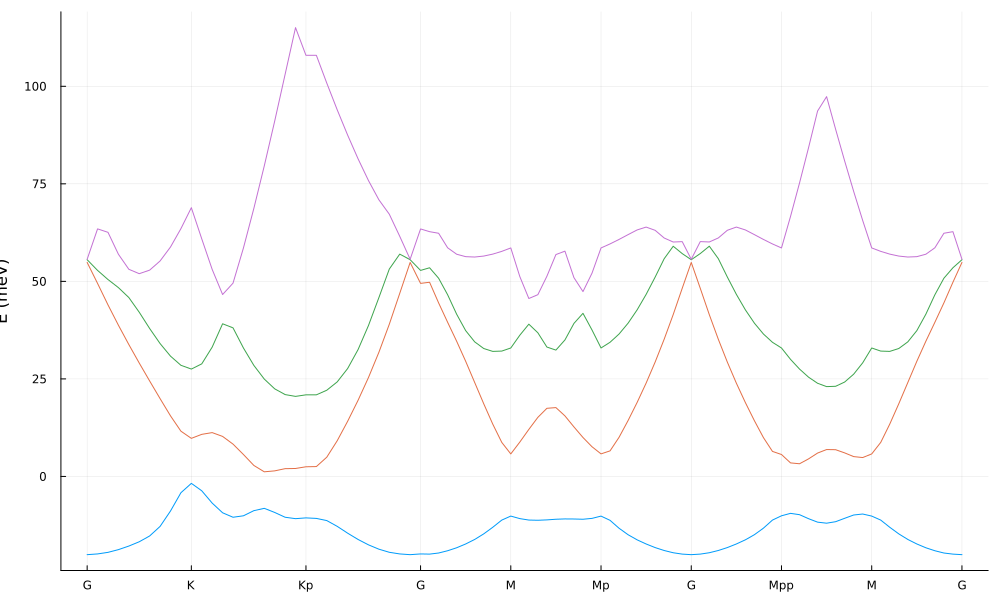

In [442]:
high_symm_line_HF()

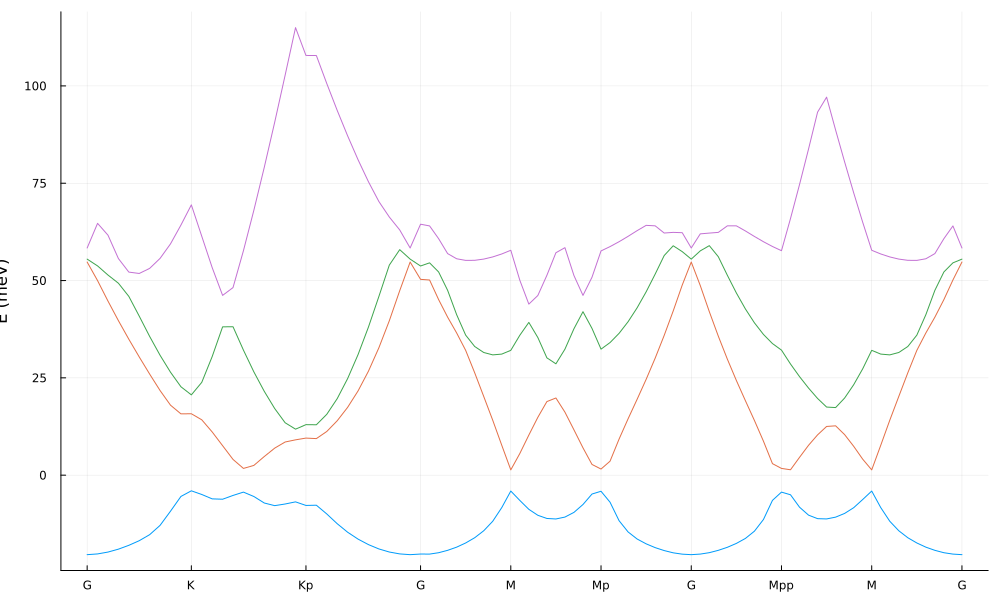

In [246]:
high_symm_line_HF()

In [50]:
function high_symm_line_HF_sv()
    delta_k = [0.0, 0.0]
    ndiv = 10
    nbandplot=nbandkeep-1
    Gamma = Gs[1, :] * 0
    K = Gs[1, :] * (1 / 3) + Gs[2, :] * (1 / 3)
    Kp = Gs[1, :] * (-1 / 3) + Gs[2, :] * (2 / 3)
    M = Gs[2, :] * (1 / 2)
    Mp = Gs[2, :] * (1 / 2)
    Mpp = Gs[4, :] * (1 / 2) 
  
    ksline = [zeros(2)]
    kabs = [0.0]
  
    # for i in 1:ndiv
    #     push!(ksline, (K - Gamma) / ndiv * i)
    #     push!(kabs, norm((K - Gamma) / ndiv) + kabs[end])
    # end
    # lab1 = kabs[end]
  
    # for i in 0:ndiv
    #     push!(ksline, K + (Kp - K) / ndiv * (i + 1))
    #     push!(kabs, norm((Kp - K) / ndiv) + kabs[end])
    # end
    # lab2 = kabs[end]
  
    # for i in 0:ndiv
    #     push!(ksline, Kp + (Gamma - Kp) / ndiv * (i + 1))
    #     push!(kabs, norm((Gamma - Kp) / ndiv) + kabs[end])
    # end
    # lab3 = kabs[end]
  
    # for i in 1:ndiv
    #     push!(ksline, (M - Gamma) / ndiv * i)
    #     push!(kabs, norm((M - Gamma) / ndiv) + kabs[end])
    # end
    # lab4 = kabs[end]
  
    # for i in 1:ndiv
    #     push!(ksline, M + (Mp - M) / ndiv * i)
    #     push!(kabs, norm((Mp - M) / ndiv) + kabs[end])
    # end
    # lab5 = kabs[end]
  
    # for i in 1:ndiv
    #     push!(ksline, Mp + (Gamma - Mp) / ndiv * i)
    #     push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
    # end
    # lab6 = kabs[end]
  



    # for i in 1:ndiv
    #     push!(ksline, (Mpp - Gamma) / ndiv * i)
    #     push!(kabs, norm((Mpp - Gamma) / ndiv) + kabs[end])
    # end
    # lab7 = kabs[end]
  
    for i in 1:ndiv
        push!(ksline, Mpp + (M - Mpp) / ndiv * i)
        push!(kabs, norm((M - Mpp) / ndiv) + kabs[end])
    end
    lab8 = kabs[end]
  
    # for i in 1:ndiv
    #     push!(ksline, M + (Gamma - M) / ndiv * i)
    #     push!(kabs, norm((Gamma - Mp) / ndiv) + kabs[end])
    # end
    # lab9 = kabs[end]
  
    ksline = hcat(ksline...)
    ksline1=reshape(ksline, 2, :)'
    kabs = collect(kabs)
  
    band = zeros(Complex{Float64}, nbandplot, length(kabs))
    for (ind, q) in enumerate(eachrow(ksline1))
      #println(ind)
      eigenvals=makeH_HF(q)
      for i in 1:nbandplot
          band[i, ind] = eigenvals[i]
      end
    end
  
    plot_size = (1000, 600)
    p = plot(size=plot_size)
    for i in 1:size(band, 1)
        plot!(kabs, real(band[i, :])-ones(size(real(band[i, :]),1))*mu,legend=false)
    end
    special_points = [lab8]
    special_labels = ["M"]
    xticks!(special_points, special_labels)
    ylabel!("E (meV)")
    display(p)
  
  end

high_symm_line_HF_sv (generic function with 1 method)

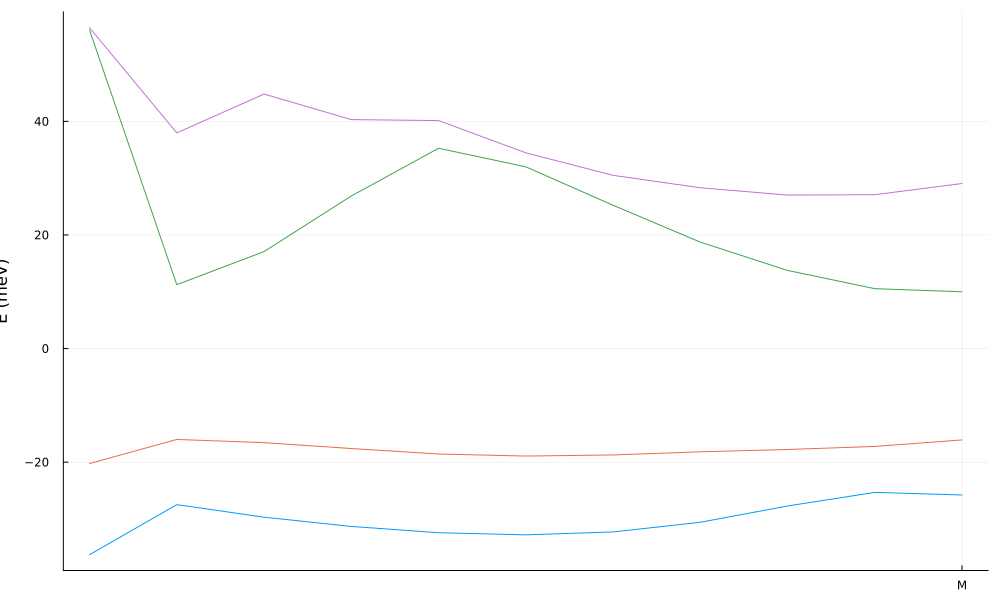

In [51]:
high_symm_line_HF_sv()

# Chern number

In [47]:
function arg(z)
    return atan(imag(z)/real(z))
end

arg (generic function with 1 method)

In [119]:
uhf=h5read(filename, "urho");
u = h5read(filename, "u");
mu = h5read(filename, "mu");

In [189]:
@einsum psi0[ik,ig,ifl] :=uhf[ik,al,5] * u[ik,al,ig,ifl]
size(psi0)

(100, 37, 8)

In [190]:
2-1-1-1-2-1

-4

In [191]:
eps0[1,:]

6-element Vector{Float64}:
 -73.19689538458817
 -10.37213220759736
  11.98511197731591
  46.61423065115971
  47.243981829316866
  49.55994452677669

In [192]:
psi=zeros(nband,l,l)*1im
for i in 1:l*l 
    for ig in 1:size(glist,1)
        for fl in 1:nflav
            psi[(ig-1)*nflav+fl,div(i-1,l)+1,mod(i-1,l)+1]=psi0[i,ig,fl]
        end
    end
end

In [193]:
function findind(ig,G)
    for (ig2,g2) in enumerate(eachrow(glist))
        if (norm(g2-glist[ig,:]-G)<1e-3)
            return ig2
        end
    end
    return 0
end

findind (generic function with 1 method)

In [194]:
psitop0=zeros(l,size(glist,1)*nflav)*1im
for i in 1:l 
    for (ig,g) in enumerate(eachrow(glist))
        for fl in 1:nflav
            if (findind(ig,Gs[1,:])>0.1)
                psitop0[i,(ig-1)*nflav+fl]=psi0[l*(i-1)+1,findind(ig,Gs[1,:]),fl]
            end 
        end
    end 
end
psiright0=zeros(l,size(glist,1)*nflav)*1im
for i in 1:l 
    for (ig,g) in enumerate(eachrow(glist))
        for fl in 1:nflav
            if (findind(ig,Gs[6,:])>0.1)
                psiright0[i,(ig-1)*nflav+fl]=psi0[i,findind(ig,Gs[6,:]),fl]
            end 
        end
    end 
end
psitr0=zeros(size(glist,1)*nflav)*1im
for i in 1:l 
    for (ig,g) in enumerate(eachrow(glist))
        for fl in 1:nflav
            if (findind(ig,Gs[6,:]+Gs[1,:])>0.1)
                psitr0[(ig-1)*nflav+fl]=psi0[1,findind(ig,Gs[6,:]+Gs[1,:]),fl]
            end 
        end
    end 
end

In [195]:
berry_curv=zeros(l,l)*im;
@time for ii = 1:(l)#Just to get rid of boundary term
    for jj = 1:(l)
        a=0.0*im;
        ip=ii+1
        jp=jj+1
        a1=psi[:,ii,jj]
        if (ii<l)
            a2=psi[:,ip,jj]
        else
            a2=psiright0[jj,:]
        end
        if (jj<l)
            a4=psi[:,ii,jp]
        else
            a4=psitop0[ii,:]
        end
        if (ii<l)
            if (jj<l)
                a3=psi[:,ip,jp]
            else 
                a3=psitop0[ip,:]
            end
        else
            if (jj<l)
                a3=psiright0[jp,:]
            else 
                a3=psitr0[:]
            end
        end
        a = (a4'*a1)*(a1'*a2)*(a2'*a3)*(a3'*a4)
        berry_curv[ii,jj] = imag(log(a/abs(a)))
    end
  end

  0.001025 seconds (2.22 k allocations: 1.901 MiB)


In [196]:
bcc=zeros(l*l)*im
bccabs=zeros(l*l)*im
@time for ii = 1:(l)#Just to get rid of boundary term
    for jj = 1:(l)
        bcc[(ii-1)*l+jj]=berry_curv[ii,jj]
        bccabs[(ii-1)*l+jj]=abs(real(berry_curv[ii,jj]))
    end
  end

  0.000193 seconds (521 allocations: 13.156 KiB)


In [197]:
Chern_Number = sum(x -> !isnan(x) ? x : 0, real(berry_curv))/(2*pi)

-2.000045365503074

┌ Warning: Skipped marker arg heatmap.
└ @ Plots C:\Users\vladp\.julia\packages\Plots\kLeqV\src\args.jl:1149


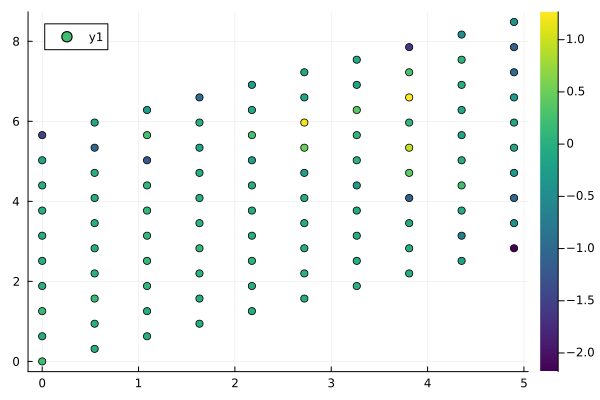

In [198]:
x_coords = ks[:,1]
y_coords = ks[:,2]
scatter(x_coords, y_coords, zcolor=real(bcc), ms=4, marker=:heatmap, color=:viridis)

  0.002534 seconds (2.46 k allocations: 175.750 KiB)


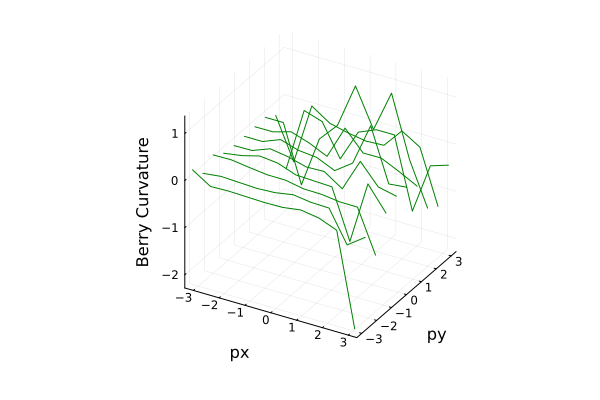

In [199]:
plim = pi
px_array = range(-plim,plim,l);
py_array = range(-plim,plim,l);
px_grid = repeat(px_array, 1, length(py_array));
py_grid = repeat(py_array', length(px_array), 1);

@time plot(px_grid,py_grid,real(berry_curv),xlabel="px",ylabel="py",zlabel="Berry Curvature",color="green",legend=false)

In [131]:
function bzfold(q)
    x, y = q
    height = π  # Distance from center to top/bottom edge of hexagon
    width = 2 * height / sqrt(3)  # Horizontal distance from center to side edges
    if abs(y) -1e-3> height
        return 0
    end
    if abs(x) -1e-3> width - abs(y) / sqrt(3)
        return 0
    end
    
    return 1
end



bzfold (generic function with 1 method)

In [132]:
ksfolded=zeros(l*l,2)
for i in 1:l*l 
    ksfolded[i,:]=ks[i,:]
    if (bzfold(ks[i,:]-Gs[1,:])==1)
        ksfolded[i,:]=ks[i,:]-Gs[1,:]
    end
    if (bzfold(ks[i,:]-Gs[6,:])==1)
        ksfolded[i,:]=ks[i,:]-Gs[6,:]
    end
    if (bzfold(ks[i,:]-Gs[1,:]-Gs[6,:])==1)
        ksfolded[i,:]=ks[i,:]-Gs[1,:]-Gs[6,:]
    end
end

┌ Warning: Skipped marker arg heatmap.
└ @ Plots C:\Users\vladp\.julia\packages\Plots\kLeqV\src\args.jl:1149


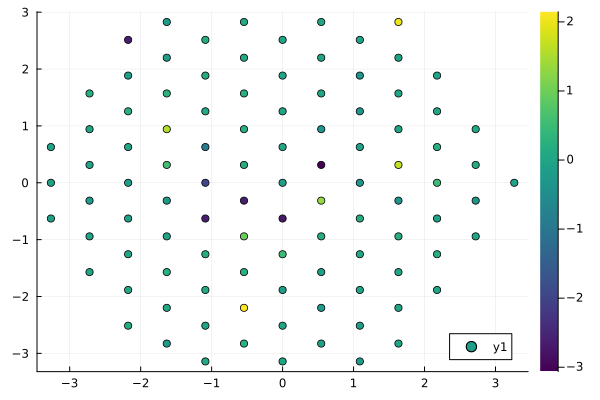

In [133]:
x_coords = ksfolded[:,1]
y_coords = ksfolded[:,2]
scatter(x_coords, y_coords, zcolor=real(bcc), ms=4, marker=:heatmap, color=:viridis)

┌ Warning: Skipped marker arg heatmap.
└ @ Plots C:\Users\vladp\.julia\packages\Plots\kLeqV\src\args.jl:1149


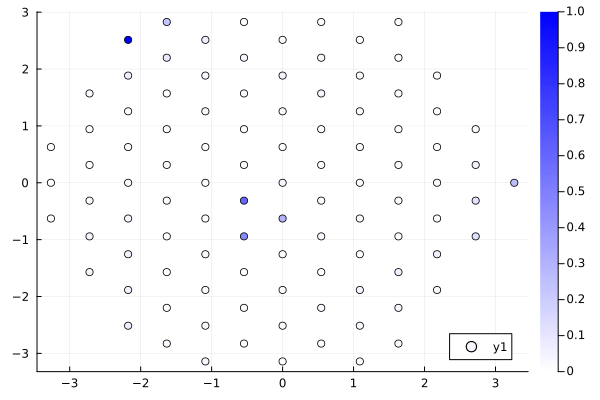

In [39]:
color_values = real(bccabs)
min_val, max_val = minimum(color_values), maximum(color_values)
normalized_colors = (color_values .- min_val) ./ (max_val - min_val)

# Define a color gradient from white to blue
color_gradient = cgrad([RGB(1, 1, 1), RGB(0, 0, 1)])  # From white to blue

# Plot with the custom color gradient
scatter(x_coords, y_coords, zcolor=normalized_colors, ms=4, marker=:heatmap, color=color_gradient)


# Garbage


In [44]:
sumG3=zeros(Int64, size(glist, 1),size(glist, 1),size(glist, 1));

for ig in 1:size(glist, 1)
    for iG in 1:size(glist, 1)
        for i in 1:size(glist, 1)
            if (norm(glist[ig,:]+glist[iG,:]-glist[i,:])<0.001)
                sumG3[ig,iG,i]=1
            end
        end    
    end
end    

In [ ]:
@einsum C[i, k] := A[i, j] * B[j, l]*D[l,k]

In [26]:
laminit[1,1,1,1,1]

3.3707143936028686e-7 + 2.50584122787217e-8im

In [31]:
laminit[1,1,1,1,2]

-1.0817020388629649e-7 - 3.4638303225208906e-9im

In [ ]:
laminit[592,234,3,3,4]

In [15]:
sizeof(monster) / (1024^3)

3.08990478515625

In [28]:
lambd(1,1,1,1,1,1)

UndefVarError: UndefVarError: `lambd` not defined

In [40]:
function v(ik, ikp, ig, li, lp)
  mom = norm(ks[ikp,:] + glist[ig,:] - ks[ik,:])
  formfactor = 1.0
  if mom < 1e-4
      return formfactor * 0.00027821508061451604 * 121.95121951219512
  end
  return formfactor * 0.00027821508061451604 * ratio / mom * tanh(mom * 121.95121951219512 / ratio)
end


v (generic function with 1 method)

In [45]:
rho=zeros(Complex{Float64},l*l,nbandkeep,nbandkeep);

In [51]:
function Heffgrid(ik)
    Heff = zeros(Complex{Float64}, nbandkeep, nbandkeep)
    h0 = diagm(eps0[ik,:])
    uh = zeros(Complex{Float64}, nbandkeep, nbandkeep)
    uf = zeros(Complex{Float64}, nbandkeep, nbandkeep)
    cou = 0
    for al in 1:nbandkeep
        for alp in 1:nbandkeep
            for ikp in 1:(l*l)
                for ig in 1:size(glist, 1)
                    for beta in 1:nbandkeep
                        for betap in 1:nbandkeep
                            for lind in 1:nflav
                                for lpind in 1:nflav
                                    uh[al, alp] += 1 / (l*l) * v(ik, ik, ig, lind, lpind) * lambd(ik, ik, ig, lind, al, alp) *
                                        conj(lambd(ikp, ikp, ig, lpind, betap, beta)) * rho[ikp, beta, betap]
                                    cou += 1
                                    println(cou)
                                end
                            end
                        end
                    end
                end
            end
        end
    end
    return Heff
end


Heffgrid (generic function with 1 method)

In [29]:
function lambdf(ik,ikp,iG,al,alp)
    ans = 0.0 + 0.0im
    for li in 1:nflav
        for (igs, Gfic) in enumerate(eachrow(glist))
            gGind = sumG[igs,iG]
            if gGind != -1
                ans += conj(u[ik, al, igs, li]) * u[ikp, alp, gGind, li]
            end
        end
    end
    return ans
    
end

lambdf (generic function with 1 method)

In [33]:
lambdf(1,1,1,1,1)

3.370714393602867e-7 + 2.5058412278721685e-8im

In [1]:
nbandkeep

UndefVarError: UndefVarError: nbandkeep not defined

In [ ]:
v(1,1,glist.shape[0]//2,0,0)

0.033928668367623906

In [ ]:
Heffgrid(1).shape

(20, 20)

In [38]:
eps0[300]

39.62311753809263

In [20]:
lambd(1,1,glist.shape[0]//2,1,1,2)

(-0.000224960133630517-0.001921466424294574j)

In [32]:
for ig in range(glist.shape[0]):
  for j1 in range(nbandkeep):
    for j2 in range(nbandkeep):
      ans=0j
      for i in range(nflav):
        ans+=lambd(523,726,ig,i,j1,j2)
      if ((np.linalg.norm(ans)>0.001)and (j1 !=j2)):
        print(ans)

(0.04462636558126313-0.02487791699147515j)
(-0.02316907045723151+0.019416788557691633j)
(-0.026724023381857198+0.020541654186399215j)
(0.03742371094475913+0.07790583413642085j)
(0.05040886953658223+0.04887095579360477j)
(-0.022497922040044353-0.047632173770726115j)
(-0.034461943183672766-0.028399948776635722j)
(0.04661606771185055-0.02121644134882359j)
(-0.008228148467278127-0.005807508519910186j)
(-0.011268783652736689+0.04242161668797812j)
(0.030645003033043492+0.06057599672782624j)
(0.028599681198334878+0.060102051335453155j)
(-0.015711348986192517-0.016233455133096583j)
(-0.036402317215402-0.06160218344127685j)
(-0.036477201473311315-0.0009448282254804247j)
(0.0011695793053055894-0.0005350614150716142j)
(0.06292503087276707+0.004596775753215337j)
(-0.028545115660419566+0.016805949639692917j)
(-0.062197409882200023+0.04069305939127107j)
(0.024093163395391227-0.0017542084196722932j)
(0.007012483186123856-0.038245622021442216j)
(-0.03259062556503784+0.006434033142490548j)
(-0.02319196

In [ ]:
fa=np.zeros((l*l,l*l,4,4,4,4))*1j
fa.nbytes / (1024 ** 2)

NameError: name 'l' is not defined

In [ ]:
@showprogress for ik in 1:l*l 
    for ikp in 1:l*l 
        for al in 1:nbandkeep
            for alp in 1:nbandkeep
                for beta in 1:nbandkeep
                    for betap in 1:nbandkeep
                        for iG in 1:size(glist, 1)
                        
                        end
                
                    end
                end                
            end
        end
   end
end

In [252]:
hdiag=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
for i in 1:l*l 
    for j in 1:nbandkeep
        hdiag[i,j,j]=eps0[i,j]
    end
end

In [294]:
ucur=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
@einsum Hcurh[ik,al,alp] := monsh[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
@einsum Hcurf[ik,al,alp] := monsf[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
Hc=hdiag+Hcurh+Hcurf
engs, us = eigen(Hc[42,:,:]);

In [293]:
us[:,1]

4-element Vector{ComplexF64}:
   0.9911865308963663 + 0.0im
 -0.08116223239531294 + 0.06314817168150606im
 0.016525839023695067 - 0.05645324700148131im
  0.04094727194658048 - 0.04286618577858385im

In [295]:
us[:,1]

4-element Vector{ComplexF64}:
 -0.12213205697532176 + 0.19090473875892613im
   0.9702429894163174 + 0.0im
 -0.03494695902492374 - 0.04885087711132906im
   0.0193028469554471 + 0.05733572033758032im

In [301]:
Hc[42,:,:]

4×4 Matrix{ComplexF64}:
  360.675-1.32965e-16im   4.42831-7.25947im      …  0.381095-0.742242im
  4.42831+7.25947im       326.352+1.06427e-17im     -1.37308+4.87382im
 -1.44937-2.22181im       2.16849+3.77168im          1.61261+0.7876im
 0.381095+0.742242im     -1.37308-4.87382im          407.465+8.90403e-18im

In [302]:
Hc[43,:,:]

4×4 Matrix{ComplexF64}:
  323.992-4.51209e-17im     4.3015+3.44814im      …   -3.71694-3.73245im
   4.3015-3.44814im        376.176-1.11139e-16im     -0.028997+1.67612im
 -1.18249+3.93478im       0.273255+0.20626im         -0.139156+1.26471im
 -3.71694+3.73245im      -0.028997-1.67612im           411.993+1.67705e-17im

In [308]:
Hcurf[42,:,:]

4×4 Matrix{ComplexF64}:
   -11.479-1.28496e-16im   5.06074-8.02963im      …  0.215207-0.954783im
   5.06074+8.02963im      -48.5066+1.06205e-17im     -2.04035+5.76845im
 -0.884753-2.69765im       2.58856+4.14114im          1.84867+0.729847im
  0.215207+0.954783im     -2.04035-5.76845im         -4.62605+3.23371e-18im

In [296]:
habc=Hc[42,:,:]
@einsum ans21[ab] := habc[ab,b] *us[b,1]
ans21

4-element Vector{ComplexF64}:
 -39.544317285283825 + 61.81176136477092im
   314.1484518274654 + 9.020562075079397e-17im
 -11.315240814429558 - 15.81709693586136im
    6.24993898751507 + 18.56434725624667im

In [291]:
abs(-0.043506138294698016 + 0.24969533875873567im)

0.25345718823335267

In [278]:
304.9397284194921/0.9466518847293366 

322.12446131312504

In [279]:
34.365907566478974im/0.10668518443581747im

322.1244613131239 - 0.0im

In [269]:
us[:,1]

4-element Vector{ComplexF64}:
  0.030122956882569323 - 0.10668518443581747im
   0.08155668031272685 + 0.291322637481968im
    0.9466518847293366 + 0.0im
 -0.004217474985305332 - 0.004788498784287415im

In [ ]:
for j in 1:l
    if (j!=1)
        uhf[(j-1)*l+1,:,1]=uhf[(j-1)*l+1,:,1]*exp(-1im*arg(sum(conj(uhf[(j-2)*l+1,a,1])*uhf[(j-1)*l+1,a,1] for a in 1:nbandkeep)))
    end
    for i in 2:(l)
        uhf[(j-1)*l+i,:,1]=uhf[(j-1)*l+i,:,1]*exp(-1im*arg(sum(conj(uhf[(j-1)*l+i-1,a,1])*uhf[(j-1)*l+i,a,1] for a in 1:nbandkeep)))
    end
end

In [ ]:
@einsum abc[n] := conj(uhf[1,ind,n]) * uhf[12,ind,n]
abc[1]


In [ ]:
udx=zeros(Complex{Float64}, l * l,size(glist,1),nflav);
udy=zeros(Complex{Float64}, l * l,size(glist,1),nflav);
dk=2*pi/l
for a in 1:size(glist,1)
    for b in 1:nflav
        for i in 1:l*l 
            xc=mod(i-1,l)
            yc=div(i-1,l)
            xcp=mod(mod(i-1+1,l*l),l)
            xcm=mod(mod(i-1-1,l*l),l)
            ycp=div(mod(i-1+1,l*l),l)
            ycm=div(mod(i-1-1,l*l),l)
            
            udy[i,a,b]=(psi[yc*l+xcp+1,a,b]-psi[yc*l+xcm+1,a,b])/(2*dk)
            udx[i,a,b]=(psi[ycp*l+xc+1,a,b]-psi[ycm*l+xc+1,a,b]+psi[ycp*l+xcm+1,a,b]-psi[ycm*l+xcp+1,a,b])/(4*dk*cos(30*pi/180))
        end
    end
end

In [ ]:
@einsum omega[ik] := 1im*(conj(udx[ik,19,n]) * udy[ik,19,n]-conj(udy[ik,19,n]) * udx[ik,19,n])
bc1=real(omega[:]);

# Parallel computing sandbox


In [33]:
a=zeros(4)*1im
for i in 1:1e7
    for j in 1:4 
        a[j]+=sin(i*j)
    end
end 
a

4-element Vector{ComplexF64}:
  1.9558914085412433 + 0.0im
 -0.2679897720791511 + 0.0im
  0.5269340135405718 + 0.0im
 -0.7596809733808553 + 0.0im

In [78]:
using Distributed

# Add worker processes if not already added
# Uncomment the line below if needed
# addprocs()

@everywhere function parallel_sum()
    local_a = zeros(ComplexF64, 4)  # Local array for each process
    for i in 1:1e7
        for j in 1:4
            local_a[j] += sin(i * j)
        end
    end
    return local_a  # Each process returns its local sum
end

# Distribute the computation and sum the results from all processes
a = reduce(+, pmap(x -> parallel_sum(), workers()))

a



4-element Vector{ComplexF64}:
  1.9558914085412433 + 0.0im
 -0.2679897720791511 + 0.0im
  0.5269340135405718 + 0.0im
 -0.7596809733808553 + 0.0im

In [41]:
Threads.threadid()


1

In [42]:
a = zeros(10)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [43]:
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end

In [44]:
a

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 3.0
 3.0
 3.0
 4.0
 4.0
 2.0
 2.0

# Iterations v2

In [ ]:
for itind in 1:100

    eng=zeros(Float64, l * l,nbandkeep);
    filling=3.0
    mu = quantile(collect(Iterators.flatten(eps0)), 1/size(eng,2)*filling);
    rho=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
    # for ind in 1:l*l
    #     rho[ind,2,2]=1
    #     rho[ind,1,1]=1
    #     rho[ind,1,2]=1
    # end
    nit=9000
    engprev=0
    urho=rand(Complex{Float64}, l * l,nbandkeep,nbandkeep);
    for ni in 1: nit
        ucur=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
        @einsum Hcurh[ik,al,alp] := monsh[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
        @einsum Hcurf[ik,al,alp] := monsf[ik,ikp,al,alp,bet,betp] * rho[ikp,bet,betp]
        Hc=hdiag+Hcurh+Hcurf
        for ik2 in 1:l*l 
            engs, us = eigen(Hc[ik2,:,:])
            #println(norm(Hc[ik2,:,:]-conj(transpose(Hc[ik2,:,:]))))
            eng[ik2,:]=real(engs)
            ucur[ik2,:,:]=us
        end
        mu = quantile(real(collect(Iterators.flatten(eng))), 1/size(eng,2)*filling)
        rho=zeros(Complex{Float64}, l * l,nbandkeep,nbandkeep);
        for jk in 1:l*l 
            for bet in 1:nbandkeep
                for betp in 1:nbandkeep
                    for n in 1:nbandkeep
                        rho[jk,bet,betp]+=conj(ucur[jk,bet,n])*ucur[jk,betp,n]/(1+exp((eng[jk,n]-mu)/0.01))
                    end  
                end
            end
        end    
        #println(eng[1,1])
        if (abs(engprev-eng[1,1])<0.01)
            break
        end
        engprev=eng[1,1]
        urho=ucur
    end
    uhf=urho;
    @einsum psi0[ik,ig,ifl] :=uhf[ik,al,3] * u[ik,al,ig,ifl]
    size(psi0)
    psi=zeros(nband,l,l)*1im
    for i in 1:l*l 
        for ig in 1:size(glist,1)
            for fl in 1:nflav
                psi[(ig-1)*nflav+fl,div(i-1,l)+1,mod(i-1,l)+1]=psi0[i,ig,fl]
            end
        end
    end
    function findind(ig,G)
        for (ig2,g2) in enumerate(eachrow(glist))
            if (norm(g2-glist[ig,:]-G)<1e-3)
                return ig2
            end 
        end
        return 0
    end
    psitop0=zeros(l,size(glist,1)*nflav)*1im
    for i in 1:l 
        for (ig,g) in enumerate(eachrow(glist))
            for fl in 1:nflav
                if (findind(ig,Gs[1,:])>0.1)
                    psitop0[i,(ig-1)*nflav+fl]=psi0[l*(i-1)+1,findind(ig,Gs[1,:]),fl]
                end 
            end
        end 
    end
    psiright0=zeros(l,size(glist,1)*nflav)*1im
    for i in 1:l 
        for (ig,g) in enumerate(eachrow(glist))
            for fl in 1:nflav
                if (findind(ig,Gs[6,:])>0.1)
                    psiright0[i,(ig-1)*nflav+fl]=psi0[i,findind(ig,Gs[6,:]),fl]
                end 
            end
        end 
    end
    psitr0=zeros(size(glist,1)*nflav)*1im
    for i in 1:l 
        for (ig,g) in enumerate(eachrow(glist))
            for fl in 1:nflav
                if (findind(ig,Gs[6,:]+Gs[1,:])>0.1)
                    psitr0[(ig-1)*nflav+fl]=psi0[1,findind(ig,Gs[6,:]+Gs[1,:]),fl]
                end 
            end
        end 
    end
    berry_curv=zeros(l,l)*im;
    @time for ii = 1:(l)#Just to get rid of boundary term
        for jj = 1:(l)
            a=0.0*im;
            ip=ii+1
            jp=jj+1
            a1=psi[:,ii,jj]
            if (ii<l)
                a2=psi[:,ip,jj]
            else
                a2=psiright0[jj,:]
            end
            if (jj<l)
                a4=psi[:,ii,jp]
            else
                a4=psitop0[ii,:]
            end
            if (ii<l)
                if (jj<l)
                    a3=psi[:,ip,jp]
                else 
                    a3=psitop0[ip,:]
                end
            else
                if (jj<l)
                    a3=psiright0[jp,:]
                else 
                    a3=psitr0[:]
                end
            end
            a = (a4'*a1)*(a1'*a2)*(a2'*a3)*(a3'*a4)
            berry_curv[ii,jj] = imag(log(a/abs(a)))
        end
    end
    Chern_Number = sum(x -> !isnan(x) ? x : 0, real(berry_curv))/(2*pi)
    println(Chern_Number)
    println(eng[1,1])
end

  0.003116 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000628 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000910 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000652 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000469 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000497 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000472 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000624 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000547 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.001027 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000553 seconds (2.33 k allocations: 1.905 MiB)
-1.000000088211238
477.0970803635812
  0.000618 seconds (2.33 k alloc

In [276]:
ud

9